# Comparison of MORDM and MORO policies

## 3 Objective

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from ema_workbench import Policy
import functools


from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.util import ema_logging
from problem_formulation import get_model_for_problem_formulation

from ema_workbench.em_framework.evaluators import (BaseEvaluator,MultiprocessingEvaluator)
from ema_workbench.analysis import parcoords

ema_logging.log_to_stderr(ema_logging.INFO)
BaseEvaluator.reporting_frequency = 0.1
# ema_logging.log_to_stderr(ema_logging.DEBUG)

C:\Users\Shajee\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Shajee\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Shajee\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
dike_model = get_model_for_problem_formulation(1)

[MainProcess/INFO] model initialized


In [3]:
def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]
    
def costs(data):
    return data[0]/1e9

SMALLER = 'SMALLER'

expected_number_of_deaths = functools.partial(robustness, SMALLER, 0.001)
expected_annual_damage = functools.partial(robustness, SMALLER, 5e5)
total_investment_costs = costs

robustness_funcs = {'Total Investment Costs': total_investment_costs,
                    'Expected Number of Deaths': expected_number_of_deaths,
                    'Expected Annual Damage': expected_annual_damage}

In [4]:
mordm_policies = pd.read_csv('MORDM_policies_20000nfe_3obj.csv', index_col=0)
mordm_policies

,A.1_DikeIncrease,A.2_DikeIncrease,A.3_DikeIncrease,A.4_DikeIncrease,A.5_DikeIncrease,0_RfR,1_RfR,2_RfR,3_RfR,4_RfR,EWS_DaysToThreat
0,7,8,10,7,10,0,0,1,1,0,3
1,6,7,10,9,10,0,0,1,1,0,3
2,6,8,10,9,10,0,0,1,1,0,3
3,6,8,10,6,10,0,0,1,1,0,3
4,6,8,10,7,10,0,0,1,1,0,3
5,6,10,10,7,10,0,0,1,1,0,3


In [5]:
policies_to_evaluate = []

for i, policy in mordm_policies.iterrows():
    policies_to_evaluate.append(Policy("mordm {}".format(i), **policy.to_dict()))

In [6]:
len(policies_to_evaluate)

6

In [7]:
moro_policies = pd.read_csv('MORO_policies_nooutcome_filtered_nfe6000_35_wooutcome.csv', index_col=0)
moro_policies
for i, policy in moro_policies.iterrows():
    policies_to_evaluate.append(Policy("moro {}".format(i), **policy.to_dict()))

In [15]:
POL_DF = pd.DataFrame(policies_to_evaluate)
POL_DF

,0_RfR,1_RfR,2_RfR,3_RfR,4_RfR,A.1_DikeIncrease,A.2_DikeIncrease,A.3_DikeIncrease,A.4_DikeIncrease,A.5_DikeIncrease,EWS_DaysToThreat
0,0,0,1,1,0,7,8,10,7,10,3
1,0,0,1,1,0,6,7,10,9,10,3
2,0,0,1,1,0,6,8,10,9,10,3
3,0,0,1,1,0,6,8,10,6,10,3
4,0,0,1,1,0,6,8,10,7,10,3
5,0,0,1,1,0,6,10,10,7,10,3
6,0,0,0,0,0,7,8,10,7,9,3
7,0,0,0,0,0,6,8,10,10,10,3
8,0,0,1,0,0,9,8,10,10,10,2
9,1,0,1,1,0,6,10,9,9,9,1


In [9]:
n_scenarios = 1000
with MultiprocessingEvaluator(dike_model) as evaluator:
    re_evaluation_results = evaluator.perform_experiments(n_scenarios,
                                                          policies_to_evaluate)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [13]:
experiments, outcomes = re_evaluation_results

overall_robustness = {}
for policy in np.unique(experiments['policy']):
    policy_robustness = {}

    logical = experiments['policy'] == policy
    
    for outcome, values in outcomes.items():
        values = values[logical]
        policy_robustness[outcome] = robustness_funcs[outcome](values)
    overall_robustness[policy] = policy_robustness
overall_robustness = pd.DataFrame.from_dict(overall_robustness).T
overall_robustness.sort_values(by = "Total Investment Costs", ascending = False)

,Expected Annual Damage,Expected Number of Deaths,Total Investment Costs
moro 3,0.929,0.956,0.439929
mordm 5,0.865,0.952,0.357099
mordm 0,0.862,0.972,0.352322
mordm 2,0.868,0.950,0.350232
mordm 4,0.832,0.949,0.348096
mordm 3,0.800,0.943,0.347112
mordm 1,0.838,0.945,0.346062
moro 2,0.899,0.964,0.243573
moro 1,0.823,0.931,0.199490
moro 0,0.768,0.935,0.198101


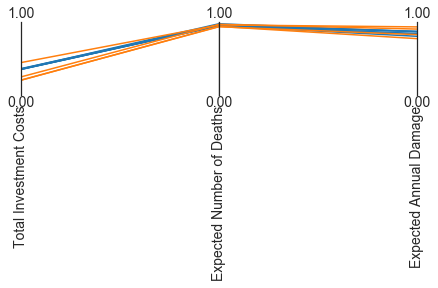

In [11]:
# we pass the column labels explicitly to ensure the same order
# as in the previous plot

mordm_policies = ['mordm 0', 'mordm 1', 'mordm 2', 'mordm 3', 'mordm 4', 'mordm 5']
moro_policies = ['moro 0', 'moro 1', 'moro 2', 'moro 3']
colors = sns.color_palette()

data = overall_robustness.loc[:, 
                              ['Total Investment Costs', 'Expected Number of Deaths', 'Expected Annual Damage']]

limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data.loc[mordm_policies,:], color=colors[0])
paraxes.plot(data.loc[moro_policies,:], color=colors[1])
plt.show()

In [32]:
#ROB = pd.DataFrame(overall_robustness)

In [33]:
#list = []
#for i in range(len(overall_robustness)):
#    list.append(i)
#ROB.index = list

In [42]:
POL_ROB = pd.concat((POL_DF,overall_robustness), axis = 1)

In [44]:
POL_ROB.index = ['mordm 0', 'mordm 1', 'mordm 2', 'mordm 3', 'mordm 4', 'mordm 5', 'moro 0', 'moro 1', 'moro 2', 'moro 3']

In [46]:
POL_ROB.to_csv('MORO_MORDM_final_3obj.csv')

In [45]:
POL_ROB

,0_RfR,1_RfR,2_RfR,3_RfR,4_RfR,A.1_DikeIncrease,A.2_DikeIncrease,A.3_DikeIncrease,A.4_DikeIncrease,A.5_DikeIncrease,EWS_DaysToThreat,Expected Annual Damage,Expected Number of Deaths,Total Investment Costs
mordm 0,0,0,1,1,0,7,8,10,7,10,3,0.862,0.972,0.352322
mordm 1,0,0,1,1,0,6,7,10,9,10,3,0.838,0.945,0.346062
mordm 2,0,0,1,1,0,6,8,10,9,10,3,0.868,0.950,0.350232
mordm 3,0,0,1,1,0,6,8,10,6,10,3,0.800,0.943,0.347112
mordm 4,0,0,1,1,0,6,8,10,7,10,3,0.832,0.949,0.348096
mordm 5,0,0,1,1,0,6,10,10,7,10,3,0.865,0.952,0.357099
moro 0,0,0,0,0,0,7,8,10,7,9,3,0.768,0.935,0.198101
moro 1,0,0,0,0,0,6,8,10,10,10,3,0.823,0.931,0.199490
moro 2,0,0,1,0,0,9,8,10,10,10,2,0.899,0.964,0.243573
moro 3,1,0,1,1,0,6,10,9,9,9,1,0.929,0.956,0.439929
